In [77]:
import pandas as pd
import fairness_metrics
import utils
import ast
import pickle
import operator
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

In [78]:
def get_max_score(row):
    row = ast.literal_eval(row)
    # max_score = sum(list(row.values()))
    max_score = max(row.items(), key=operator.itemgetter(1))[1]
    return max_score

def get_max_class(row):
    row = regard_map[row]
    # row = ast.literal_eval(row)
    max_class = max(row.items(), key=operator.itemgetter(1))[0]
    return max_class

In [79]:
# gender based subset
gender_features = ['male', 'female', 'transgender', 'other_gender']
# race based subset
race_features = ['asian', 'black', 'latino', 'white', 'other_race_or_ethnicity']
# disability based subset
disability_features = ['intellectual_or_learning_disability', 'physical_disability', 'psychiatric_or_mental_illness', 'other_disability']
# sexual orientation subset
sexual_orientation_features = ['heterosexual', 'homosexual_gay_or_lesbian', 'bisexual', 'other_sexual_orientation']

labels = [gender_features, race_features, disability_features, sexual_orientation_features]
names = ['gender', 'race', 'disability', 'sexual_orientation']

In [80]:
# load the relevant datasets
ideology_df = pd.read_csv('./data/processed_annotated_comments.csv')
ideology_df['label'] = ideology_df['label'].apply(lambda x: None if x not in ['left', 'right'] else x)
ideology_df.dropna(inplace=True)

gender_df = pd.read_csv('./data/jigsaw/gender.csv')
race_df = pd.read_csv('./data/jigsaw/race.csv')
disability_df = pd.read_csv('./data/jigsaw/disability.csv')
sexual_orientation_df = pd.read_csv('./data/jigsaw/sexual_orientation.csv')

In [81]:
def make_moderated(df, moderation_map):
    moderations = []
    new_df = df.copy()
    for text in df['text']:
        if text in moderation_map.keys():
            moderations += [moderation_map[text]]
        else:
            new_df = new_df[new_df.text != text]

    df = new_df.copy()

    df['flagged'] = moderations

    return df

In [82]:
datasets = [ideology_df, gender_df, race_df, disability_df, sexual_orientation_df]
labels = [list(set(df['label'])) for df in datasets]
names = ['ideology', 'gender', 'race', 'disability', 'sexual orientation']
factors = ['positive', 'negative', 'neutral', 'other']

In [83]:
# cases to consider
label_map = {}
label_map['ideology'] = 'left' 
label_map['gender'] = 'male'
label_map['race'] = 'white'
label_map['disability'] = 'physical_disability'
label_map['sexual orientation'] = 'heterosexual'

In [84]:
# load regard map
with open('./results/comment_regard.pkl', 'rb') as handle:
    regard_map = pickle.load(handle)

In [85]:
def get_metrics(datasets, names, moderation_map):
    metrics = []
    for dataset, name in zip(datasets, names):
        dataset = make_moderated(dataset.copy(), moderation_map)
        subset = utils.process_dataset(dataset.copy(), label_map[name])
        # demographic parity
        dp = fairness_metrics.demographic_parity(df=subset.copy())
        
        # add regard
        regard = subset.copy()['text'].apply(get_max_class)

        csp = []
        for factor in factors:
            csp += [fairness_metrics.conditional_statistical_parity(df=subset.copy(), factors=regard, factor=factor)]
        csp += [dp, name, label_map[name]]
        metrics += [csp]
    columns = factors+['dp', 'bias', 'group']
    columns = [column.upper() for column in columns]
    df = pd.DataFrame(metrics, columns = columns)
    return df

In [86]:
with open('./results/comments_moderated_openai.pkl', 'rb') as handle:
    moderation_map_openai = pickle.load(handle)

with open('./results/unirand_comments.pkl', 'rb') as handle:
    moderation_map_unirand = pickle.load(handle)

with open('./results/comment_moderation_clarifai.pkl', 'rb') as handle:
    moderation_map_clarifai = pickle.load(handle)

with open('./results/comments_moderation_google_perspective.pkl', 'rb') as handle:
    moderation_map_perspective = pickle.load(handle)

with open('./results/comments_moderation_google.pkl', 'rb') as handle:
    moderation_map_google = pickle.load(handle)

In [87]:
moderation_map_openai = utils.process_openai(moderation_map_openai)
moderation_map_clarifai = utils.process_clarifai(moderation_map_clarifai)
moderation_map_perspective = utils.process_perspective(moderation_map_perspective)
moderation_map_google = utils.process_google(moderation_map_google)

20


In [88]:
df_unirand = get_metrics(datasets=datasets.copy(), names=names, moderation_map=moderation_map_unirand)
df_openai = get_metrics(datasets=datasets.copy(), names=names, moderation_map=moderation_map_openai)
df_clarifai = get_metrics(datasets=datasets.copy(), names=names, moderation_map=moderation_map_clarifai)
df_google = get_metrics(datasets=datasets.copy(), names=names, moderation_map=moderation_map_google)
df_perspective = get_metrics(datasets=datasets.copy(), names=names, moderation_map=moderation_map_perspective)

In [89]:
df_unirand

,POSITIVE,NEGATIVE,NEUTRAL,OTHER,DP,BIAS,GROUP
0,0.393939,0.001894,0.012821,0.105591,0.046022,ideology,left
1,0.016461,0.001163,0.018391,0.002786,0.001314,gender,male
2,0.000226,0.001579,0.015270,0.006442,0.000662,race,white
3,0.122959,0.003522,0.066989,0.002011,0.006176,disability,physical_disability
4,0.111951,0.053667,0.171235,0.064838,0.018349,sexual orientation,heterosexual


In [90]:
df_openai

,POSITIVE,NEGATIVE,NEUTRAL,OTHER,DP,BIAS,GROUP
0,0.016835,0.096978,0.133903,0.037015,0.445169,ideology,left
1,0.035566,0.069451,0.041305,0.065510,0.437321,gender,male
2,0.099565,0.004377,0.047073,0.067373,0.141023,race,white
3,0.012117,0.012490,0.073129,0.079862,0.421599,disability,physical_disability
4,0.039835,0.189717,0.264440,0.211094,0.201864,sexual orientation,heterosexual


In [91]:
df_clarifai

,POSITIVE,NEGATIVE,NEUTRAL,OTHER,DP,BIAS,GROUP
0,0.045455,0.001933,0.025641,0.044808,0.717590,ideology,left
1,0.003946,0.003623,0.000816,0.004200,0.857385,gender,male
2,0.001381,0.028581,0.001635,0.011816,0.865142,race,white
3,0.016327,0.068683,0.023042,0.022913,0.796961,disability,physical_disability
4,0.027473,0.089495,0.099707,0.017664,0.863373,sexual orientation,heterosexual


In [92]:
df_google

,POSITIVE,NEGATIVE,NEUTRAL,OTHER,DP,BIAS,GROUP
0,0.021886,0.057184,0.068376,0.047341,0.551013,ideology,left
1,0.027574,0.000718,0.023842,0.033944,0.458642,gender,male
2,0.043877,0.001797,0.012793,0.017714,0.453372,race,white
3,0.012372,0.057699,0.025339,0.004301,0.756325,disability,physical_disability
4,0.092720,0.052978,0.142420,0.008488,0.578168,sexual orientation,heterosexual


In [93]:
df_perspective

,POSITIVE,NEGATIVE,NEUTRAL,OTHER,DP,BIAS,GROUP
0,0.028620,0.016062,0.011396,0.050263,0.641134,ideology,left
1,0.004941,0.003729,0.003342,0.003711,0.796640,gender,male
2,0.018962,0.049763,0.006841,0.024858,0.701286,race,white
3,0.024490,0.101355,0.029458,0.026549,0.710586,disability,physical_disability
4,0.032967,0.137021,0.225806,0.071639,0.737344,sexual orientation,heterosexual


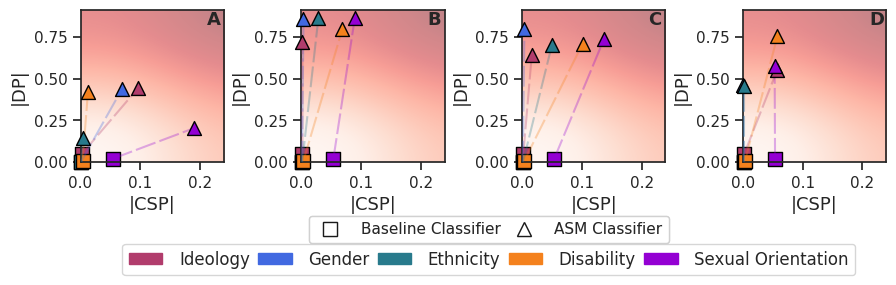

In [94]:
# visualize the results
import fairness_visualization
import seaborn as sns
import matplotlib.patches as mpatches

sns.set_theme()
sns.set_style("ticks")
color_1 = (sns.color_palette("flare")[3], sns.color_palette("flare")[3], sns.color_palette("flare")[3])
color_2 = ("royalblue", "royalblue", "royalblue")
color_3 = (sns.color_palette("crest")[3], sns.color_palette("crest")[3], sns.color_palette("crest")
[3])
color_4 = (sns.color_palette("YlOrBr")[3], sns.color_palette("YlOrBr")[3],
sns.color_palette("YlOrBr")[3])
color_5 = ("darkviolet", "darkviolet", "darkviolet")
colors = [color_1, color_2, color_3, color_4, color_5]
dfs = [df_openai, df_clarifai, df_perspective, df_google]
names = ['A', 'B', 'C', 'D']
tuples_main_xy = [(a,b) for a,b in zip(df_unirand['NEGATIVE'], df_unirand['DP'])]

fig, ax = plt.subplots(1, 4, figsize=(9, 2.6))
x_max = -1
y_max = -1
for i in range(0, len(ax)):
    tuples_xy = [(a,b) for a,b in zip(dfs[i]['NEGATIVE'], dfs[i]['DP'])]
    local_max_y = max(max(dfs[i]['DP'].tolist()), max(df_unirand['DP'].tolist()))
    local_max_x = max(max(dfs[i]['NEGATIVE'].tolist()), max(df_unirand['NEGATIVE'].tolist()))
    if  local_max_x > x_max:
        x_max = local_max_x
    if local_max_y > y_max:
        y_max = local_max_y


    fairness_visualization.plot_specific(ax[i], tuples_main_xy, tuples_xy, colors)
    ax[i].text(x=0.88, y=0.9, s=names[i], fontsize=13, weight="bold", transform=ax[i].transAxes)

for i in range(0, len(ax)):
    ax[i].set_xlim(0, min(x_max+0.05, 1))
    ax[i].set_ylim(0, min(y_max+0.05, 1))

markers = ['s', '^']
marker_texts = ['Baseline Classifier', 'ASM Classifier']
new_patches = [plt.plot([], [], marker=markers[i], ms=10, ls="", mec='k', mfc='w',
                label="{:s}".format(marker_texts[i]))[0] for i in range(2)]
legend1 = fig.legend(handles=new_patches, bbox_to_anchor=(0.54, 0.09),prop={'size': 11},
                        loc='center', ncol=5, handletextpad=1, labelspacing=1, columnspacing=0.5)

ax[1].add_artist(legend1)

plt.tight_layout(pad=1)
fig.subplots_adjust(bottom=0.35)
colors = [color_1[0], color_2[0], color_3[0], color_4[0], color_5[0]]
texts = ["Ideology", "Gender", "Ethnicity", "Disability", "Sexual Orientation"]
patches = [mpatches.Patch(color=colors[i], label=texts[i]) for i in range(len(texts))]
fig.legend(handles=patches, bbox_to_anchor=(0.54, -0.025),prop={'size': 12},
loc='center', ncol=5, handletextpad=1, labelspacing=1, columnspacing=0.5)

plt.show()